Agente ReACT con LangGraph Components

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
import os


In [3]:
# Esta herramienta realizará una búsqueda en internet
# y devolverá un máximo de 4 resultados relevantes para la consulta realizada
tool = TavilySearchResults(max_results=4) 
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Nota: En take_action abajo, se añadió algo de lógica para cubrir el caso en que el LLM devuelve un nombre de herramienta inexistente. Incluso con la llamada a funciones, los LLMs todavía pueden ocasionalmente inventar información. ¡Cabe destacar que lo único que se hace es indicarle al LLM que intente nuevamente! Es una ventaja de una organización con Agente.

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        # Inicializa el agente con un modelo, un conjunto de herramientas y un 
        # mensaje del sistema opcional, y construye un grafo de estados que alterna 
        # entre invocar al LLM y ejecutar acciones.
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)


    def exists_action(self, state: AgentState):
        # Comprueba si el último mensaje generado por el modelo incluye
        #  llamadas a herramientas para decidir si debe pasar al estado de acción.
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        # Envía los mensajes acumulados al modelo de lenguaje (añadiendo el mensaje del
        #  sistema si existe) y devuelve la respuesta del LLM.
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        # Ejecuta las llamadas a herramientas solicitadas por el modelo, captura sus resultados y los envía de
        # vuelta al LLM como mensajes de herramienta.
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
ChatOpenAI.api_key = os.getenv("OPENAI_API_KEY")
prompt = """
Eres un asistente de investigación inteligente. Utiliza el motor de búsqueda para buscar información.
Puedes realizar múltiples consultas (ya sea juntas o en secuencia).
Solo busca información cuando estés seguro de lo que necesitas.
Si necesitas buscar información antes de hacer una pregunta de seguimiento, ¡puedes hacerlo!
"""

model = ChatOpenAI(model="gpt-4o-mini")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

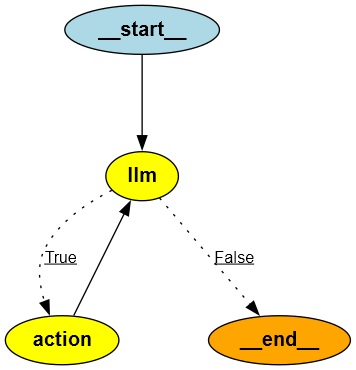

In [7]:
import pygraphviz
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="cual es la temperatura en san francisco?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'temperatura actual en San Francisco'}, 'id': 'call_028czRzNN6zeWN47ZEijwN9k', 'type': 'tool_call'}
Back to the model!


In [9]:
import pprint
pprint.pprint(result)

{'messages': [HumanMessage(content='cual es la temperatura en san francisco?', additional_kwargs={}, response_metadata={}),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_028czRzNN6zeWN47ZEijwN9k', 'function': {'arguments': '{"query":"temperatura actual en San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 150, 'total_tokens': 174, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ca5c7975-3bd8-402e-a54f-2c60315c7c3c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'temperatura actual en San Francisco'}, 'id': 'call_02

In [10]:
result['messages'][-1].content

'La temperatura actual en San Francisco es de aproximadamente 63 grados Fahrenheit (alrededor de 17°C). Para esta tarde-noche, se espera que la temperatura descienda hasta los 54 grados Fahrenheit (alrededor de 12°C). \n\nSi deseas más información sobre el clima, puedes consultar [Weather and Radar](https://es.weatherandradar.com/tiempo/san-francisco/3575911).'

In [11]:
messages = [HumanMessage(content="Cual es la temperatura en San Francisco y Los Angeles?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'temperatura actual en San Francisco'}, 'id': 'call_IVbYLo7hlFJvLkDtLlz2c2Id', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'temperatura actual en Los Angeles'}, 'id': 'call_BNbjob4j3PDSrPAEGPltct80', 'type': 'tool_call'}
Back to the model!


In [13]:
result['messages'][-1].content

'La temperatura actual en San Francisco es de aproximadamente **63°F (17°C)**, y se espera que descienda a **54°F (12°C)** más tarde. Para más detalles, puedes consultar [este enlace](https://es.weatherandradar.com/tiempo/san-francisco/3575911).\n\nEn Los Ángeles, la temperatura actual es de **13°C (55°F)**, y se espera que alcance una máxima de **24°C (75°F)** durante el día. Para más información, puedes visitar [este enlace](https://www.tiempo3.com/north-america/usa/california/los-angeles).'

In [14]:
# Nota: la consulta fue modificada para producir resultados más consistentes.
# Los resultados pueden variar en cada ejecución y a lo largo del tiempo, ya que la información de búsqueda y los modelos cambian.

query = "¿Quién ganó el Super Bowl en 2024? ¿En qué estado se encuentra la sede del equipo ganador?" \
"¿Cuál es el PBI de ese estado? Responde cada pregunta." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o-mini")  
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 ganador'}, 'id': 'call_KnuIWZZxPmzriePiiH0DTmIa', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'PBI Nevada 2024'}, 'id': 'call_acUIePmWiN2A0TSAkVs29KHc', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'PBI de Nevada 2023'}, 'id': 'call_x3U3NcYtgp28sxfbtYfvAO4s', 'type': 'tool_call'}
Back to the model!


In [15]:
print(result['messages'][-1].content)

1. **¿Quién ganó el Super Bowl en 2024?**
   El Super Bowl en 2024 fue ganado por los Kansas City Chiefs, quienes derrotaron a los San Francisco 49ers con un marcador de 25-22 en tiempo extra.

2. **¿En qué estado se encuentra la sede del equipo ganador?**
   La sede del equipo ganador, los Kansas City Chiefs, se encuentra en el estado de Missouri.

3. **¿Cuál es el PBI de ese estado?**
   El Producto Bruto Interno (PBI) de Missouri en 2023 es de aproximadamente 331,6 mil millones de dólares.
